In [65]:
import torch

Load names dataset

In [66]:
words = open('names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Get all characters used, and assign ids to characters. We'll also use a special character '.' to denote the beginning and end of a string.

We use stoi and itos to convert between chars and ids.

In [67]:
chars = ['.'] + sorted(list(set(''.join(words))))

stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

In order to build a bigram model with counting, we simply count the occurances of each bigram in the dataset and store them in N.

Where N[i][j] holds the number of times the bigram (i,j) occurs in the dataset.

Then, we can compute P, which normalizes N along its rows to get the probability of j given i.

In [68]:
N = torch.zeros((28, 28), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        N[ix1, ix2] += 1

P = N / N.sum(1, keepdim=True)

We can use this handy function from lecture to visualize the bigram matrix.

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
def gridplot(G):
    plt.figure(figsize=(16,16))

    plt.imshow(N, cmap='Blues')
    for i in range(27):
        for j in range(27):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha='center', va='bottom', color='black')
            plt.text(j, i, f'{G[i,j].item():.2f}', ha='center', va='top', color='black')
    plt.axis('off')

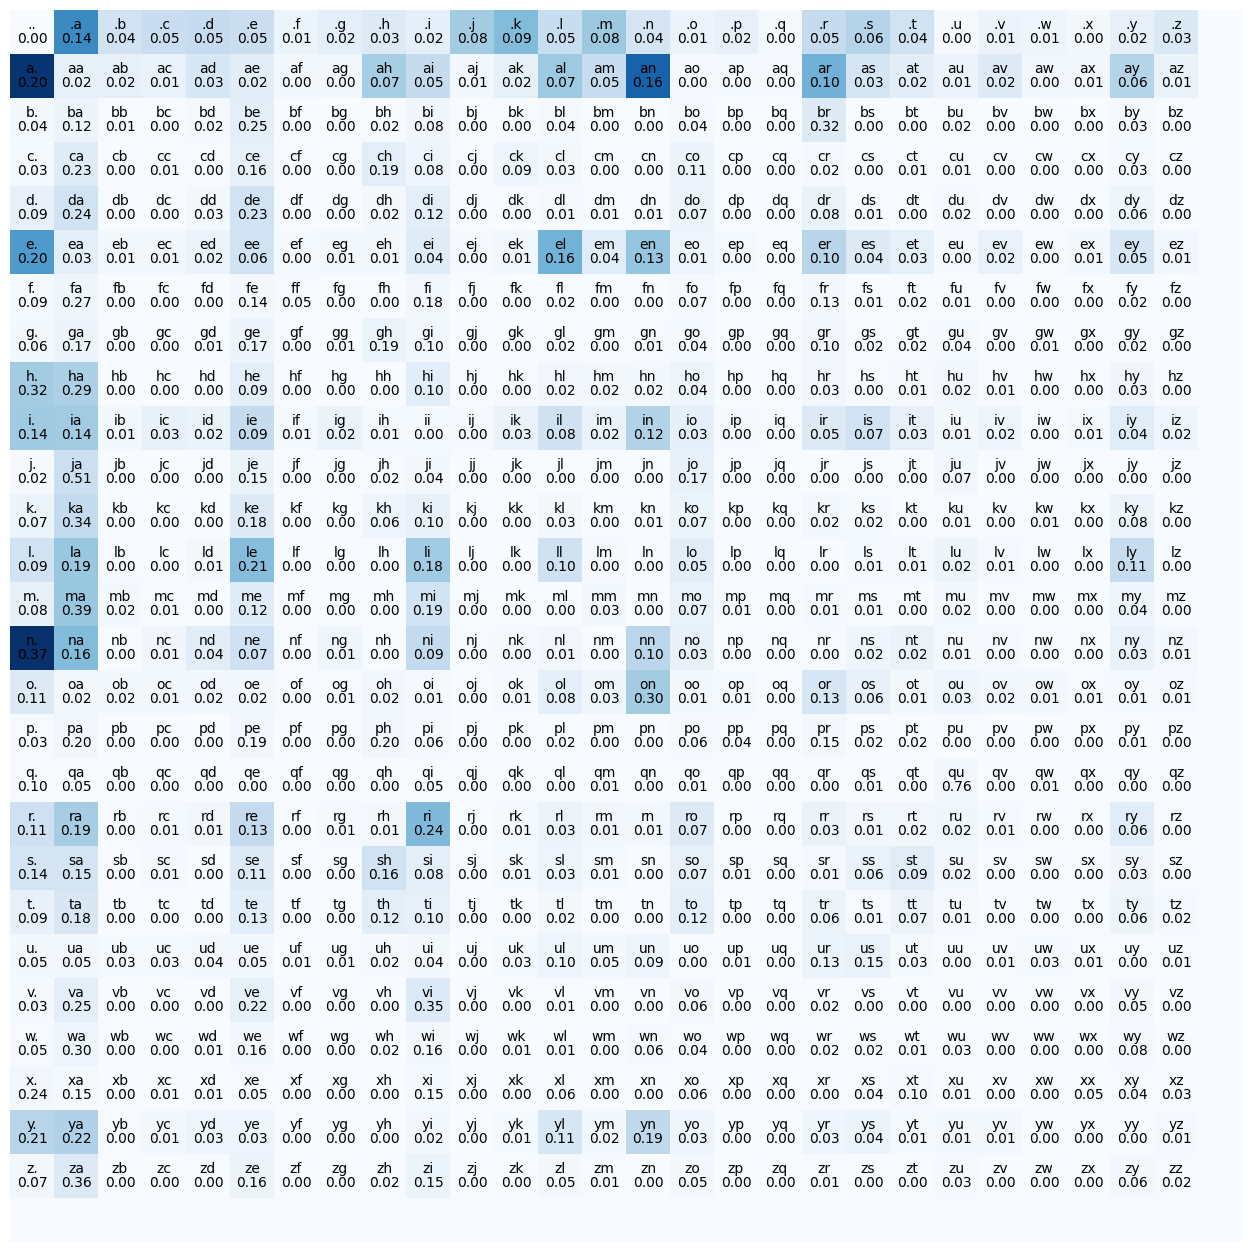

In [71]:
gridplot(P)

Then to generate names, we simply sample from the distribution of the next character given the current character, until we get the begin/end character '.' (id=0).

We can calculate the likelihood of a generated name by multiplying the probabilities of each bigram in the name.
Alternatively, we can use the log-likelihood, which is the sum of the log-probabilities of each bigram in the name, divided by the number of samples.

In [95]:
def generate(ma):
    logprob_sum = 0.0
    count = 0
    ix = 0
    name = []
    count = 0
    while True:
        ix2 = torch.multinomial(ma[ix], 1, replacement=False).item()
        logprob_sum += torch.log(ma[ix, ix2])
        count += 1
        if ix2 == 0:
            break
        name.append(itos[ix2])
        ix = ix2
    return ''.join(name), logprob_sum, count

for _ in range(10):
    name, logprob_sum, count = generate(P)
    print(f"{''.join(name)} (log-likelihood: {-logprob_sum/count:0.3f})")

da (log-likelihood: 2.004)
lloym (log-likelihood: 3.241)
h (log-likelihood: 2.376)
kslya (log-likelihood: 2.507)
ja (log-likelihood: 1.630)
a (log-likelihood: 1.806)
enniayle (log-likelihood: 2.207)
cha (log-likelihood: 1.889)
phahiy (log-likelihood: 2.385)
llilo (log-likelihood: 2.482)


Names with a lower log-likelihood are more likely to be generated by the model than words with higher log-likelihood loss values.

We can also compute the log-likelihood loss of our model over many samples, to measure the quality of samples that our model produces.

In [73]:
num_samples = 1000
logprob_sum = 0.0
count = 0
for i in range(num_samples):
    _, ls, c = generate(P)
    logprob_sum += ls
    count += c
print(f"Average log-likelihood: {-logprob_sum/count:0.3f}")

Average log-likelihood: 2.442


An alternative approach to bigram models is to train a neural network to predict the next character, given the previous one. We want to build a model that take in a character, and outputs a probability distribution over all possible next characters.

We can build a simple model using a single linear layer and a softmax activation.

We start by initializing a 27x27 matrix of weights to random values. This is similar to the bigram matrix, but instead of counting the number of times each bigram occurs, we will *learn* the weights of the bigram matrix via gradient descent.

In [74]:
weights = torch.randn((27, 27), requires_grad=True)

Next we can create a training set of bigrams from the dataset:

In [75]:
xs, ys = [], []

for word in words:
    chs = ['.'] + list(word) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

We'll convert the inputs to one-hot encoding vectors so that we can use them to extract the corresponding probabilities from the weight matrix via a dot product.

In [76]:
xs = torch.nn.functional.one_hot(xs, 27).float()

Then, we can run gradient descent iterations to update the weight of the model such that the log-likelihood loss is minimized on the training set. 

We can use the dot product to extract logits from the weights matrix and then apply softmax to normalize the outputs. We'll apply all these operations in a vectorized manner across the entire batch of inputs. If the dataset was too large we could consider breaking it up into batches but for our purposes we can just use the entire training set.

In [77]:
gradient_descent_iterations = 1000
learning_rate = 20.0

for i in range(gradient_descent_iterations):

    logits = xs @ weights
    
    # --- softmax --- # 
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    # < logits = torch.nn.functional.softmax(logits, dim=1) >
    # ---------------

    # get log-probability of each sample
    loss = -probs[torch.arange(len(ys)), ys].log().mean()

    loss.backward()
    weights.data -= learning_rate * weights.grad
    weights.grad = None
    if i % 25 == 0:
        print(f"[Step {i}] Average log-likelihood: {loss.item():0.3f}")

[Step 0] Average log-likelihood: 3.854
[Step 25] Average log-likelihood: 2.673
[Step 50] Average log-likelihood: 2.565
[Step 75] Average log-likelihood: 2.528
[Step 100] Average log-likelihood: 2.508
[Step 125] Average log-likelihood: 2.497
[Step 150] Average log-likelihood: 2.489
[Step 175] Average log-likelihood: 2.484
[Step 200] Average log-likelihood: 2.480
[Step 225] Average log-likelihood: 2.476
[Step 250] Average log-likelihood: 2.474
[Step 275] Average log-likelihood: 2.472
[Step 300] Average log-likelihood: 2.470
[Step 325] Average log-likelihood: 2.469
[Step 350] Average log-likelihood: 2.467
[Step 375] Average log-likelihood: 2.466
[Step 400] Average log-likelihood: 2.465
[Step 425] Average log-likelihood: 2.465
[Step 450] Average log-likelihood: 2.464
[Step 475] Average log-likelihood: 2.463
[Step 500] Average log-likelihood: 2.463
[Step 525] Average log-likelihood: 2.462
[Step 550] Average log-likelihood: 2.462
[Step 575] Average log-likelihood: 2.461
[Step 600] Average lo

Because our neural net is essentially converging to the bigram matrix, we'd expect the log-likelihood loss to converge to a similar/identical value, which it does.

In order to achieve a better model, we'd need to introduce more inputs (i.e. more previous characters) as well as introduce more complexity to the model (i.e. more layers). We will do this in the next unit.

We can sample from the model in a simliar fashion to how we sampled from the bigram matrix:

In [107]:
normalized_weights = torch.nn.functional.softmax(weights, dim=1)

for _ in range(10):
    name, logprob_sum, count = generate(normalized_weights)
    print(f"{''.join(name)} (log-likelihood: {-logprob_sum/count:0.3f})")

rika (log-likelihood: 2.158)
bra (log-likelihood: 1.916)
ce (log-likelihood: 2.178)
ie (log-likelihood: 2.666)
jun (log-likelihood: 2.176)
yava (log-likelihood: 2.469)
lle (log-likelihood: 2.139)
be (log-likelihood: 2.079)
donamanamen (log-likelihood: 2.035)
me (log-likelihood: 2.089)
